In [1]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam, SGD
from torch import nn
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)

In [3]:
transform = Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_path = "./mnist_data"
mnist_trainset = datasets.MNIST(root=mnist_path, train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root=mnist_path, train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
model = Network().to(device)
optimizer = Adam(model.parameters(), lr=0.0005)
torch.random.manual_seed(1)
np.random.seed(1)
torch.cuda.manual_seed(1)
for epoch in range(3):
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss_robust = F.cross_entropy(y_pred, y)
        loss_robust.backward()
        optimizer.step()
        if (i + 1 % 500) == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss {loss_robust.item()}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            _, predicted = torch.max(y_pred.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print(f"Epoch {epoch}, Accuracy {correct / total}")

Epoch 0, Accuracy 0.9823
Epoch 1, Accuracy 0.9845
Epoch 2, Accuracy 0.9891


In [6]:
model = model.eval()
correct = 0
total = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    _, predicted = torch.max(y_pred.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()

print('Accuracy:', correct / total)

Accuracy: 0.9891


In [7]:
def tweak_input(learning_rate, image, model, verbose=True):
    """
    Performs gradient ascent to maximize the activations of a given layer.
    
    Args:
    - n_iterations: the number of iterations to perform
    - learning_rate: the learning rate of the optimizer
    - image: the image to optimize
    - model: the model to use
    - layer: the layer from which to extract the activations
    
    Returns:
    - image: the enhanced image
    """
    model = model.eval()
    res = model(image)
    _, top2 = res.topk(2)[1][0]
    image.requires_grad = True
    iter_count = 0
    optimizer = SGD([image], lr=learning_rate)
    while True:
        if iter_count > 20_000:
            print("Failed to converge")
            break
        # if image.grad is not None:
        #     image.grad.zero_()   
        optimizer.zero_grad()     
        res = model(image)
        loss = -res[0, top2]
        new_top1, _ = res.topk(2)[1][0]
        if new_top1 == top2:
            # print("Took:", iter_count, "iterations")
            break
        loss.backward()
        optimizer.step()
        # with torch.no_grad():
        #     image.grad /= torch.abs(image.grad).mean()
        #     image += learning_rate * image.grad
        if i % 20 == 0 and verbose:
            print(f"Iteration {i}, Loss: {loss.item()}")
        iter_count += 1
    return image.detach(), iter_count

Previous Pred: 9
Perturbed_pred: 7


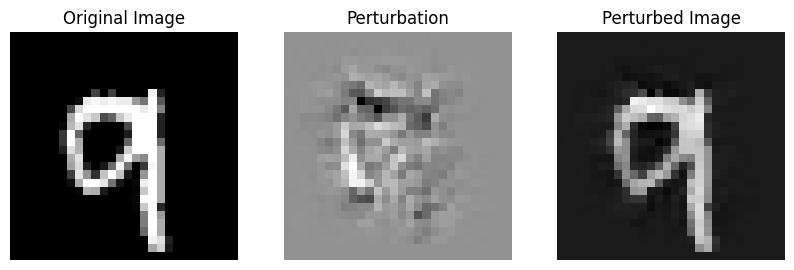

In [8]:
layers = [(n, l) for n, l in model.named_children()]
model = model.eval()
show = 1
torch.random.manual_seed(8)
for x, y in train_loader:
    x = x.to(device)
    if show == 0:
        break
    imgs = x[0]
    res_robust = model(imgs.unsqueeze(0))
    top1, top2 = res_robust.topk(2)[1][0]

    print('Previous Pred:', top1.item())
    images = imgs.unsqueeze(0).clone()

    enhanced_images, _ = tweak_input(learning_rate=0.005, image=images, model=model, verbose=False)
    res_robust = model(enhanced_images)
    top1, top2 = res_robust.topk(2)[1][0]
    print('Perturbed_pred:', top1.item())
    # Convert the tensor to a displayable image
    enhanced_image_np = enhanced_images.cpu().squeeze().numpy()
    # enhanced_image_np = np.clip(enhanced_image_np, 0, 1)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(imgs.cpu().squeeze().numpy(), cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(imgs.cpu().squeeze().numpy() - enhanced_image_np, cmap="gray")
    axes[1].set_title("Perturbation")
    axes[1].axis("off")
    axes[2].imshow(enhanced_image_np, cmap="gray")
    axes[2].set_title("Perturbed Image")
    axes[2].axis("off")
    # plt.savefig('adversarial_attack.png', bbox_inches='tight')
    plt.show()
    show -= 1
    if show == 0:
        break